# OctResNet-18 Experiments

Here we train the ResNet-18 network and a ResNet-18 network with Octave Convolution layers on a baby, overfit experiment taken from the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [1]:
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
import OctResNet
%load_ext autoreload
%autoreload 2

In [2]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

Information about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [3]:
data_dir = 'tiny-imagenet-200/'

In [4]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [5]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 0


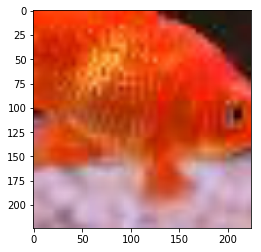

In [6]:
sample = image_datasets['train'][100]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

## Vanilla ResNet-18 Model

Here we load the ResNet-18 model from torchvision.models

## Training ResNet-18

In [7]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
train_losses = [0]
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_last = 0.0
            running_corrects = 0

            # Iterate over data.
            iter_count = 1
            for inputs, labels in dataloaders[phase]:
#                 print("Iterating over batch of size {}".format(len(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if iter_count % 50 == 0:
                    time_elapsed = time.time() - since
                    print('Average loss over iteration {} to {} =  {:.4f}'.format(iter_count - 50, iter_count, (running_loss - running_loss_last)/(iter_count*inputs.shape[0])))
                    print('Time elapsed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
                    train_losses.append((running_loss - running_loss_last)/(iter_count*inputs.shape[0]))
                    running_loss_last = running_loss
                iter_count += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
overfit_losses = []
def overfit_model(model, criterion, optimizer, num_batches=2000, batch_size=4, scheduler=None, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Collect small dataset
    overfit_target = []
    batch_count = 0
    for inputs, labels in dataloaders['train']:
#                 print("Iterating over batch of size {}".format(len(inputs)))
        overfit_target.append((inputs, labels))
        batch_count += 1
        if batch_count == num_batches:
            break
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in overfit_target:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (num_batches*batch_size)
            overfit_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
octresnet18 = OctResNet.tinyoctresnet18(pretrained=False, progress=True).to(device)

In [10]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(octresnet18.parameters(), lr=learning_rate)
overfit_losses = []
overfit_model(octresnet18, loss_fn, optimizer, num_batches=100, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0222 Acc: 0.0050
Epoch 1/29
----------
train Loss: 0.0180 Acc: 0.0725
Epoch 2/29
----------
train Loss: 0.0138 Acc: 0.2850
Epoch 3/29
----------
train Loss: 0.0120 Acc: 0.3725
Epoch 4/29
----------
train Loss: 0.0103 Acc: 0.4125
Epoch 5/29
----------
train Loss: 0.0083 Acc: 0.5525
Epoch 6/29
----------
train Loss: 0.0066 Acc: 0.6725
Epoch 7/29
----------
train Loss: 0.0056 Acc: 0.7125
Epoch 8/29
----------
train Loss: 0.0042 Acc: 0.8500
Epoch 9/29
----------
train Loss: 0.0028 Acc: 0.9175
Epoch 10/29
----------
train Loss: 0.0019 Acc: 0.9575
Epoch 11/29
----------
train Loss: 0.0011 Acc: 0.9800
Epoch 12/29
----------
train Loss: 0.0007 Acc: 0.9875
Epoch 13/29
----------
train Loss: 0.0004 Acc: 0.9925
Epoch 14/29
----------
train Loss: 0.0004 Acc: 0.9950
Epoch 15/29
----------
train Loss: 0.0002 Acc: 0.9975
Epoch 16/29
----------
train Loss: 0.0001 Acc: 0.9975
Epoch 17/29
----------
train Loss: 0.0000 Acc: 1.0000
Epoch 18/29
----------
train Loss: 0.0

OctaveResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1bn): OctConv2dBN(
        (conv_hh): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_hl): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
        (bn_h): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn_l): BatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace)
      (conv2bn): OctConv2dBN(
        (conv_hh): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_ll): Conv2d(16, 16, kernel_size=(3, 3), s

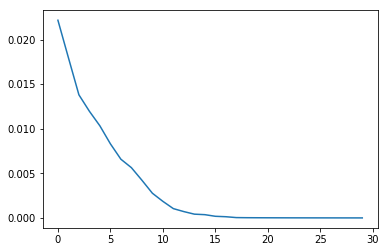

In [11]:
plt.plot(overfit_losses)
plt.show()
overfit_losses_stored = [overfit_losses.copy()]

In [12]:
resnet18 = torchvision.models.resnet18(pretrained=False).to(device)

In [13]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
overfit_losses = []
overfit_model(resnet18, loss_fn, optimizer, num_batches=100, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0262 Acc: 0.0050
Epoch 1/29
----------
train Loss: 0.0196 Acc: 0.0500
Epoch 2/29
----------
train Loss: 0.0169 Acc: 0.1025
Epoch 3/29
----------
train Loss: 0.0151 Acc: 0.2150
Epoch 4/29
----------
train Loss: 0.0139 Acc: 0.2525
Epoch 5/29
----------
train Loss: 0.0126 Acc: 0.3475
Epoch 6/29
----------
train Loss: 0.0109 Acc: 0.5450
Epoch 7/29
----------
train Loss: 0.0094 Acc: 0.6825
Epoch 8/29
----------
train Loss: 0.0078 Acc: 0.8225
Epoch 9/29
----------
train Loss: 0.0064 Acc: 0.9150
Epoch 10/29
----------
train Loss: 0.0051 Acc: 0.9850
Epoch 11/29
----------
train Loss: 0.0038 Acc: 0.9925
Epoch 12/29
----------
train Loss: 0.0028 Acc: 0.9975
Epoch 13/29
----------
train Loss: 0.0022 Acc: 1.0000
Epoch 14/29
----------
train Loss: 0.0015 Acc: 1.0000
Epoch 15/29
----------
train Loss: 0.0011 Acc: 1.0000
Epoch 16/29
----------
train Loss: 0.0009 Acc: 1.0000
Epoch 17/29
----------
train Loss: 0.0007 Acc: 1.0000
Epoch 18/29
----------
train Loss: 0.0

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

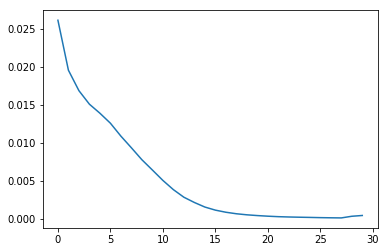

In [14]:
plt.plot(overfit_losses)
plt.show()
overfit_losses_stored = [overfit_losses.copy()]